# Demand Forecasting

In [ ]:
!pip install pandas numpy matplotlib seaborn plotly scikit-learn xgboost prophet statsmodels tensorflow google-generativeai
!pip install -U kaleido

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import xgboost as xgb
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import google.generativeai as genai
from google.colab import drive

In [ ]:
# Set up Gemini AI
API_KEY = "your-api-key" #Your Api Key
genai.configure(api_key=API_KEY)

In [ ]:
drive.mount('/content/drive')
base_path = "/content/drive/My Drive/data"  # Change this if your files are in a different folder

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset : -

Rossmann Dataset - https://drive.google.com/file/d/1RLUf6NEpRg6sefWqt-nyqLDyMEHryxrl/view?usp=share_link

Store Dataset :-https://drive.google.com/file/d/1Tu5r9A1Izhf0JabF473mmyj3jGW-RqnB/view?usp=*sharing*

In [ ]:
sales_data_path = os.path.join(base_path, 'Rossmann_Stores_Data.csv')
store_data_path = os.path.join(base_path, 'store.csv')

sales_df = pd.read_csv(sales_data_path, low_memory=False)
store_df = pd.read_csv(store_data_path, low_memory=False)

In [ ]:
# Merge datasets
df = pd.merge(sales_df, store_df, on='Store', how='left')

In [ ]:
# Preprocess data
def preprocess_data(df):
    df.drop_duplicates(inplace=True)
    df.dropna(inplace=True)

    # Detect date and sales columns dynamically
    def detect_columns(df):
        date_col = None
        sales_col = None
        for col in df.columns:
            if "date" in col.lower():
                date_col = col
            if "sales" in col.lower():
                sales_col = col
        if not date_col or not sales_col:
            raise ValueError(f"Unable to detect date or sales columns. Available columns: {list(df.columns)}")
        return date_col, sales_col

    date_col, sales_col = detect_columns(df)

    df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors='coerce')
    df[sales_col] = pd.to_numeric(df[sales_col], errors='coerce')
    df = df.dropna(subset=[date_col, sales_col])  # Ensure valid date and sales values

    df['month'] = df[date_col].dt.to_period('M').astype(str)
    df = df.groupby('month', as_index=False)[sales_col].sum()

    return df, 'month', sales_col

df, date_col, sales_col = preprocess_data(df)

<ipython-input-74-9441fb8a0c2a>:21: UserWarning:

Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.



In [ ]:
# Dataset First Look
print("First Look at Sales Data:")
sales_df.head()

First Look at Sales Data:


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [ ]:
sales_df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [ ]:
sales_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
print("\nState Holiday Value Counts:")
sales_df['StateHoliday'].value_counts()


State Holiday Value Counts:


,count
StateHoliday,
0,986159
a,20260
b,6690
c,4100


In [ ]:
print("\nUnique Dates:")
sales_df['Date'].unique()


Unique Dates:


array(['2015-07-31', '2015-07-30', '2015-07-29', '2015-07-28',
       '2015-07-27', '2015-07-26', '2015-07-25', '2015-07-24',
       '2015-07-23', '2015-07-22', '2015-07-21', '2015-07-20',
       '2015-07-19', '2015-07-18', '2015-07-17', '2015-07-16',
       '2015-07-15', '2015-07-14', '2015-07-13', '2015-07-12',
       '2015-07-11', '2015-07-10', '2015-07-09', '2015-07-08',
       '2015-07-07', '2015-07-06', '2015-07-05', '2015-07-04',
       '2015-07-03', '2015-07-02', '2015-07-01', '2015-06-30',
       '2015-06-29', '2015-06-28', '2015-06-27', '2015-06-26',
       '2015-06-25', '2015-06-24', '2015-06-23', '2015-06-22',
       '2015-06-21', '2015-06-20', '2015-06-19', '2015-06-18',
       '2015-06-17', '2015-06-16', '2015-06-15', '2015-06-14',
       '2015-06-13', '2015-06-12', '2015-06-11', '2015-06-10',
       '2015-06-09', '2015-06-08', '2015-06-07', '2015-06-06',
       '2015-06-05', '2015-06-04', '2015-06-03', '2015-06-02',
       '2015-06-01', '2015-05-31', '2015-05-30', '2015-

In [ ]:
print("\nMissing Values in Sales Data:")
sales_df.isnull().sum()


Missing Values in Sales Data:


,0
Store,0
DayOfWeek,0
Date,0
Sales,0
Customers,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0


In [ ]:
print("\nStore Data Info:")
store_df.info()


Store Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [ ]:
print("\nUnique School Holidays:")
sales_df['SchoolHoliday'].unique()


Unique School Holidays:


array([1, 0])

In [ ]:
print("\nMissing Values in Store Data:")
store_df.isnull().sum()


Missing Values in Store Data:


,0
Store,0
StoreType,0
Assortment,0
CompetitionDistance,3
CompetitionOpenSinceMonth,354
CompetitionOpenSinceYear,354
Promo2,0
Promo2SinceWeek,544
Promo2SinceYear,544
PromoInterval,544


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
image_folder = "/content/drive/My Drive/Images"
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
store_df.fillna({
    'CompetitionDistance': 0,
    'CompetitionOpenSinceMonth': 0,
    'CompetitionOpenSinceYear': 0,
    'Promo2SinceWeek': 0,
    'Promo2SinceYear': 0,
    'PromoInterval': 0
}, inplace=True)

final1 = pd.merge(sales_df, store_df, on='Store', how='left')

# Convert categorical values to numeric
state_holiday_map = {'0': 0, 'a': 1, 'b': 2, 'c': 3}
store_type_map = {'a': 0, 'b': 1, 'c': 2, 'd': 3}

final1['StateHoliday'] = final1['StateHoliday'].map(state_holiday_map).astype(int)
final1['StoreType'] = final1['StoreType'].map(store_type_map).astype(int)

# Convert date to datetime format
final1['Date'] = pd.to_datetime(final1['Date'])

# Convert necessary columns to integer type
cols_to_int = ['CompetitionOpenSinceYear', 'Promo2SinceYear', 'CompetitionDistance', 'Promo2SinceWeek']
final1[cols_to_int] = final1[cols_to_int].astype(int)

# Display final processed table
final1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2,a,1270,9.0,2008,0,0,0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,0,a,570,11.0,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,0,a,14130,12.0,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,2,c,620,9.0,2009,0,0,0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,0,a,29910,4.0,2015,0,0,0,0


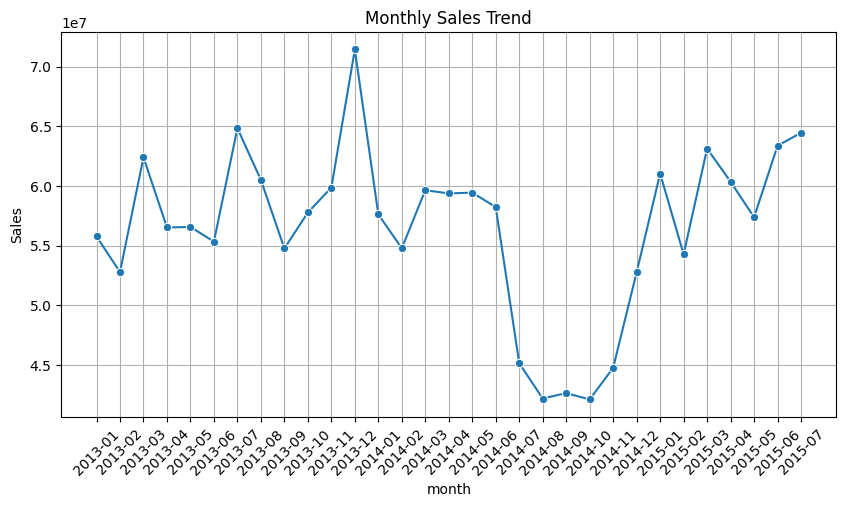

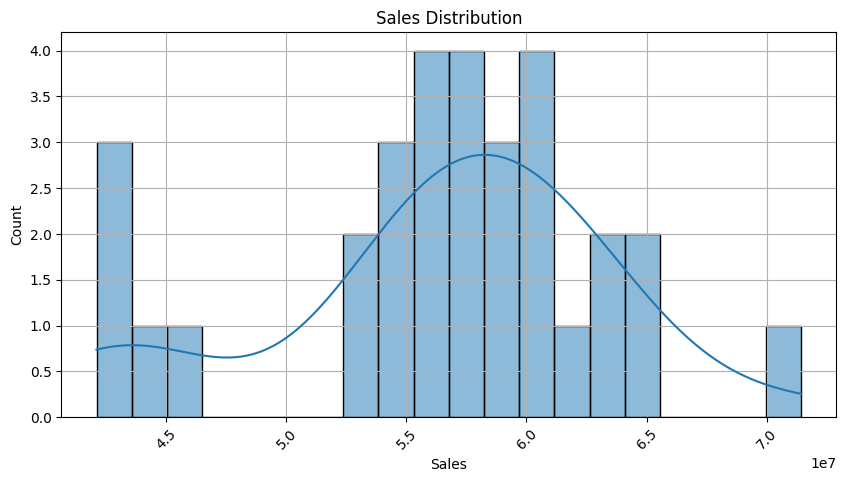

In [118]:
pio.renderers.default = 'colab'

def plot_sales_trend(df, date_col, sales_col):
    plots = [
        ('monthly_sales_trend.png', lambda: sns.lineplot(x=df[date_col], y=df[sales_col], marker='o', linestyle='-')),
        ('sales_distribution.png', lambda: sns.histplot(df[sales_col], bins=20, kde=True)),
    ]

    for filename, plot_func in plots:
        plt.figure(figsize=(10, 5))
        plot_func()
        plt.title(filename.replace('.png', '').replace('_', ' ').title())
        plt.xticks(rotation=45)
        plt.grid(True)
        save_path = os.path.join(image_folder, filename)
        plt.savefig(save_path, bbox_inches='tight')
        plt.show()
        plt.close()

    # Interactive Plotly Chart
    fig = px.line(df, x=date_col, y=sales_col, title='Monthly Sales Trend (Interactive)')
    fig.show()

# Function call
plot_sales_trend(df, date_col, sales_col)

In [95]:
# Forecasting Models
def train_arima(df, sales_col):
    model = ARIMA(df[sales_col], order=(2,1,2))
    model_fit = model.fit()
    return model_fit

def train_prophet(df, date_col, sales_col):
    df_prophet = df.rename(columns={date_col: 'ds', sales_col: 'y'})
    model = Prophet()
    model.fit(df_prophet)
    return model

def train_xgboost(df, sales_col):
    df['month_num'] = pd.to_datetime(df['month']).dt.month
    df['year'] = pd.to_datetime(df['month']).dt.year
    X = df[['month_num', 'year']]
    y = df[sales_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = xgb.XGBRegressor(objective='reg:squarederror')
    model.fit(X_train, y_train)
    return model

In [96]:
# AI-Driven Sales Advisor Chatbot
def sales_advisor_chatbot(sales_data, images):
    model = genai.GenerativeModel("gemini-1.5-flash")
    prompt = f"You are a sales forecasting advisor. Based on the following sales data and visualizations, provide strategic insights, potential demand trends, and suggestions for optimizing inventory and sales strategies:\n\n{sales_data.to_string()}\n\nVisualizations:\n"
    for image in images:
        prompt += f"![{image}]({image})\n"
    response = model.generate_content(prompt)
    return response.text

# Train Models
arima_model = train_arima(df, sales_col)
prophet_model = train_prophet(df, date_col, sales_col)
xgboost_model = train_xgboost(df, sales_col)

# Get sales advisory insights
images = [
    'Images/monthly_sales_trend.png',
    'Images/sales_distribution.png'
]
insights = sales_advisor_chatbot(df, images)
print("\n🤖 Sales Advisor Insights:\n")
print(insights)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzfrvwvlf/x1a0h0q6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzfrvwvlf/okb54pz6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=825', 'data', 'file=/tmp/tm


🤖 Sales Advisor Insights:

## Sales Forecasting and Strategy Optimization: Insights and Recommendations

The provided data and visualizations reveal a complex sales pattern requiring a multi-faceted approach to forecasting and optimization.  Let's break down the key insights and actionable recommendations:

**I. Demand Trends and Forecasting:**

* **Seasonality:** A strong seasonal pattern is evident. Sales generally peak in December and March, with lower sales during July-August and February.  This suggests a likely influence of holidays (December) and potentially weather-related factors (March) influencing demand.  Further investigation into specific product categories could refine this understanding.

* **Year-over-Year Decline (2014):** A significant drop in sales occurred in 2014, particularly noticeable from July onwards.  This requires thorough investigation. The visualizations focusing on competitor activity (`sales_competition_open_since_year.png`, `sales_competition_open_sin